In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_validate
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

# get the outcome

In [2]:
outcomes_full_surg = pd.read_csv('iaip_data/Datasets/form6c.csv')
outcome_serious = pd.DataFrame({
    'id': outcomes_full_surg.subjectid,
    'outcome_surge': np.ones(outcomes_full_surg.subjectid.size)
})

In [3]:
# Intra-abdominal injury diagnosed in the ED/during hospitalization by any diagnostic method
# 1 is yes
# 2 is no -> remap to 0
outcomes_full_pi = pd.read_csv('iaip_data/Datasets/form6b.csv')
outcomes_full_pi.keys()
outcomes_full_pi['id'] = outcomes_full_pi['SubjectID'] 
idxs = outcomes_full_pi['IAIinED1'] == 2
outcomes_full_pi.loc[idxs, 'IAIinED1'] = 0
outcomes = outcomes_full_pi[['id', 'IAIinED1']]

# make full data matrix

In [14]:
demographics = pd.read_csv('iaip_data/Datasets/demographics.csv')
demographics['id'] = demographics['SubjectID']

In [5]:
how = 'inner'
X_merged = pd.merge(demographics, outcomes, on='id', how=how)
print('potential keys:', X_merged.keys())
X = pd.DataFrame()
for k in ['RACE', 'SEX']:
    X[k] = X_merged[k].astype(str)
for k in ['ageinyrs']:
    X[k] = X_merged[k].astype(float)

print(X.keys())

potential keys: Index(['SubjectID', 'SEX', 'RACE', 'OTHER_RACE', 'HISPANIC_ETHNICITY',
       'ageinyrs', 'id', 'IAIinED1'],
      dtype='object')
Index(['RACE', 'SEX', 'ageinyrs'], dtype='object')


In [6]:
X_feats = pd.get_dummies(X)
X_np = X_feats.values
feature_names = list(X_feats)
y_np = X_merged['IAIinED1']

# prediction

In [54]:
max_depth = 2
m = DecisionTreeClassifier(max_depth=max_depth)
m_cv = cross_validate(m, X_np, y_np, cv=5, return_train_score=True, return_estimator=True)

In [57]:
m_cv['test_score']

array([0.53726708, 0.584375  , 0.578125  , 0.503125  , 0.55      ])

In [59]:
np.mean(m_cv['train_score'])

0.5699134652886115

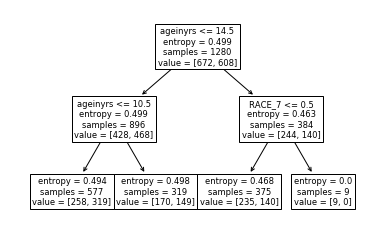

In [60]:
m_fit = m_cv['estimator'][0]
plot_tree(m_fit, feature_names=feature_names)
plt.show()

# look at all dsets

In [64]:
ddir = 'iaip_data/Datasets'
fnames = sorted([fname for fname in os.listdir(ddir) 
                 if 'csv' in fname
                 and not 'formats' in fname])
# demographics = pd.read_csv('iaip_data/Datasets/demographics.csv')
# print(fnames)

In [66]:
r = {}
for fname in tqdm(fnames):
    df = pd.read_csv(oj(ddir, fname), engine='python')
    df.rename(columns={'SubjectID': 'id'}, inplace=True)
    df.rename(columns={'subjectid': 'id'}, inplace=True)
    assert('id' in df.keys())
    r[fname] = df

100%|██████████| 68/68 [00:01<00:00, 47.42it/s]


In [80]:
num_patients = np.unique(r[fnames[0]]['id'].values).size
missing_arr = np.zeros((len(fnames), num_patients + 1), dtype=np.bool)

for i, fname in enumerate(fnames):
    df = r[fname]
    ids = np.unique(df.id.values)
#     print(np.min(ids), np.max(ids))
    missing_arr[i, ids] = 1

<Figure size 3600x6000 with 0 Axes>

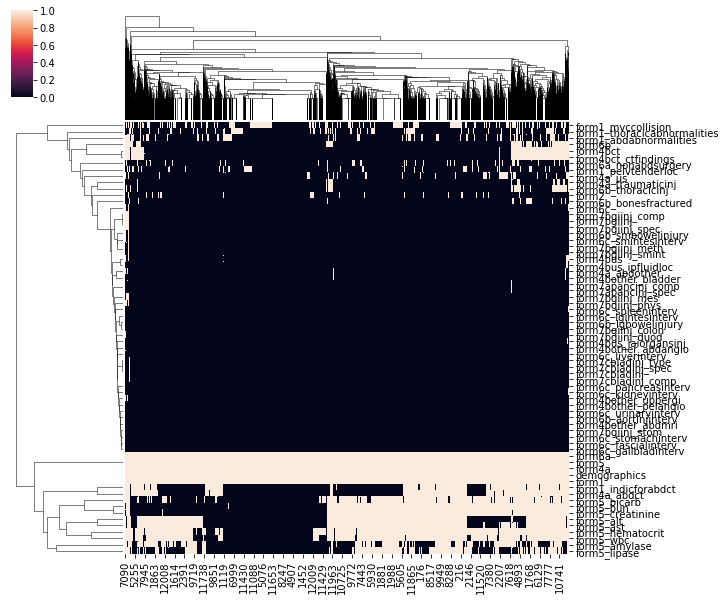

In [90]:
# plt.imshow(not_missing)
plt.figure(figsize=(12, 20), dpi=300)
sns.clustermap(missing_arr, yticklabels=[fname[:-4] for fname in fnames])
# plt.tight_layout()
plt.savefig('missing.png')
plt.show()